<a href="https://colab.research.google.com/github/makkimaki/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/main/Chapter3_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q -q -q install japanize-matplotlib
!pip -q -q -q install seaborn==0.12
!pip -q -q -q install numpyro
!pip -q -q -q install 'pymc>=5.9'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az
import scipy
import scipy.stats as stats
from numpy.random import multinomial
import matplotlib as mtl
from mpl_toolkits.mplot3d import Axes3D
# from IPython.core.pylabtools import figsize
# figsize(10, 4)
mtl.style.use("ggplot")

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
print(f"{scipy.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.10.4'
sns.__version__='0.12.0'
np.__version__='1.25.2'
scipy.__version__='1.11.4'


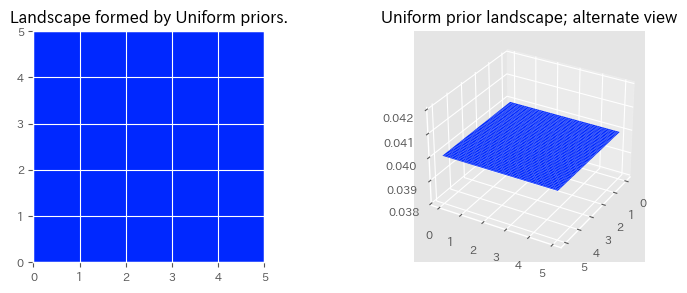

In [4]:
jet = plt.cm.jet
fig = plt.figure(figsize=(9, 3))
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

# ax, fig = plt.figure(figsize=(12,4))
# plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

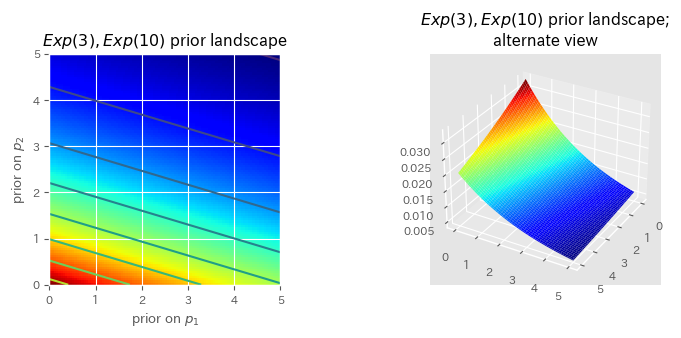

In [5]:
fig = plt.figure(figsize=(9, 3))
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation="none", origin="lower",
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("prior on $p_1$")
plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view")
plt.show()


↑これまでに、２次元の事前分布（指数関数）を可視化した。

これより、データ点を与えて事後分布がどのように更新されるかを見る。
1.

In [6]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

In [7]:
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N,1)),
    stats.poisson.rvs(lambda_2_true, size=(N,1))
], axis=1)
print(f"observed (2-dimensional, sample size={N, data})")

x = y = np.linspace(0.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x) for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 0], _y) for _y in y]).prod(axis=1)
Lilkelihood_2d = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional, sample size=(1, array([[0, 1]])))


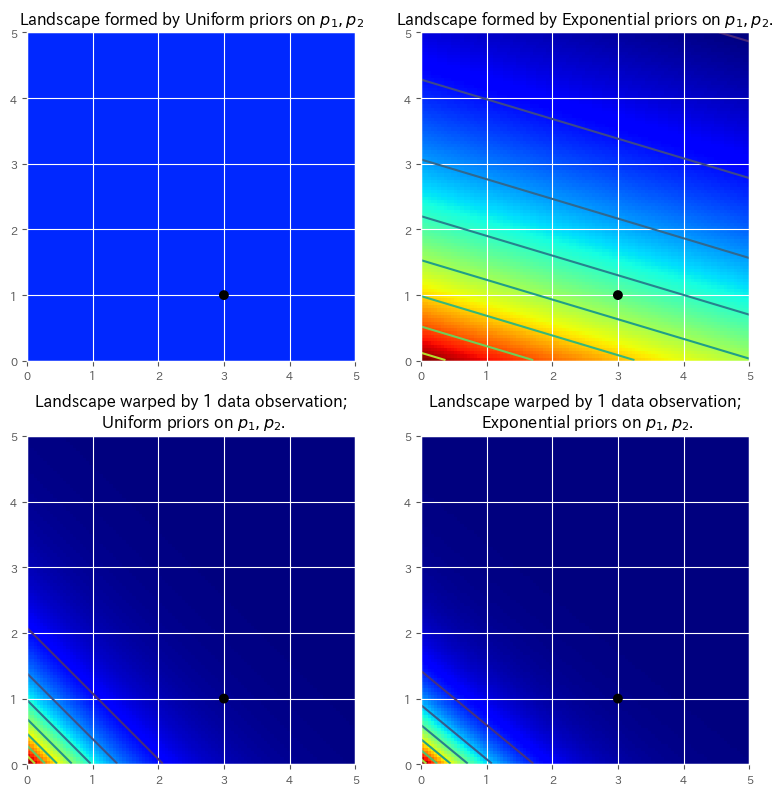

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation="none", origin="lower",
                cmap=jet, vmax=1, vmin=-0.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$")

plt.subplot(223)
plt.contour(x, y, M * Lilkelihood_2d)
im = plt.imshow(M * Lilkelihood_2d, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title(f"Landscape warped by {N} data observation;\n Uniform priors on $p_1, p_2$.")
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * Lilkelihood_2d)
im = plt.imshow(M * Lilkelihood_2d, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title(f"Landscape warped by {N} data observation;\n Exponential priors on $p_1, p_2$.")
plt.xlim(0, 5)
plt.ylim(0, 5);

plt.tight_layout()
plt.show()

In [9]:
M

array([[0.033, 0.033, 0.033, ..., 0.020, 0.020, 0.020],
       [0.033, 0.032, 0.032, ..., 0.020, 0.020, 0.020],
       [0.032, 0.032, 0.032, ..., 0.020, 0.020, 0.019],
       ...,
       [0.007, 0.006, 0.006, ..., 0.004, 0.004, 0.004],
       [0.006, 0.006, 0.006, ..., 0.004, 0.004, 0.004],
       [0.006, 0.006, 0.006, ..., 0.004, 0.004, 0.004]])

In [10]:
from urllib.request import urlretrieve
import os

os.makedirs("data", exist_ok=True)
urlretrieve("https://git.io/vXt6b", "data/mixture_data.csv")

('data/mixture_data.csv', <http.client.HTTPMessage at 0x7b807e927e20>)

[115.857 152.262 178.874 162.935 107.028 105.191 118.383 125.377 102.881
 206.713] ...


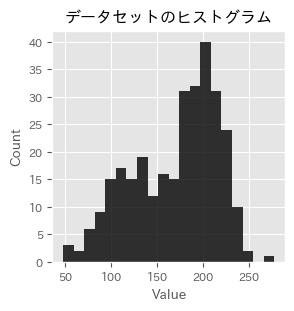

In [11]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)

plt.title("データセットのヒストグラム")
plt.ylim([0, None])
plt.xlabel("Value")
plt.ylabel("Count")
print(data[:10], "...")


二峰性がある。データ生成過程をモデリングするのに良い例。
1. あくデータ点について、確率$p$でクラスタ0、そうでなければクラスタ１を選択する
1. パラメータ$\mu_i$, $\sigma_i$の正規分布から値を１つサンプリングする。$i$はクラスタ番号
1. 繰り返し

上に登場したパラメータは全て未知数で、これらを観測データから学習させる。

データ点をクラスタに割り当てる⇨カテゴリカル分布を使おう。（確率を要素とした長さ$k$のarray）  
※考え方：カテゴリカル分布のarray、$[p, 1-p]$の$p$を一様分布からサンプリングする。したがって

In [12]:
import pytensor.tensor as pt
import pytensor

with pm.Model() as model:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = pt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p,
                                size=data.shape[0],
                                initval=np.random.randint(0, 2, data.shape[0])
                                )

print(f"{data.shape=}")
print(f"prior assignment, with p = {pm.draw(p)}")
# print(model_sample.initial_values)  # error直らない

data.shape=(300,)
prior assignment, with p = [0.472 0.528]


- $\mu$, $\sigma$に対したそれぞれ２つずつ事前分布を設定する
    - 二峰の平均値は見た目からそれぞれ120, 190あたりと言っていい
    - ばらつき$\sigma$も事前分布が必要で今回は10とする

便利な書き方
```
sds = pm.Uniform("sds", 0, 100, shape=2)
```

In [13]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)

    centers = pm.Normal("centers",
                        mu=np.array([120, 190]),
                        sigma=np.array([10, 10]),
                        shape=2)

    center_i = pm.Deterministic("center_i", centers[assignment])
    sd_i = pm.Deterministic("sd_i", sds[assignment])

    observations = pm.Normal("obs", mu=center_i, sigma=sd_i, observed=data)

print("Random assignments: ", pm.draw(assignment)[:4], "...")
print("Assignment center: ", pm.draw(center_i)[:4], "...")
print("Assignment standard deviation: ", pm.draw(sd_i)[:4], "...")

Random assignments:  [0 0 0 0] ...
Assignment center:  [197.196 112.091 112.091 112.091] ...
Assignment standard deviation:  [73.195  7.510 73.195 73.195] ...


In [14]:
%%time
pytensor.config.compute_test_value = 'off'
with model:
    # We use the CategoricalGibbsMetropolis, and return_inferencedata=False here for compatibility.
    step1 = pm.Metropolis(vars=[p1,sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace1 = pm.sample(25000, step=[step1, step2],
                       return_inferencedata=False,
                       tune=5000,
                       chains=1,
                    #    nuts_sampler="numpyro"
                       )

    # Use the default NUTS for sampling, and we return the Arviz InferenceData
    step3 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace2 = pm.sample(25000, step=[step3],
                       tune=5000,
                       chains=1,
                    #    nuts_sampler="numpyro"
                       )

CPU times: user 39min 44s, sys: 17.1 s, total: 40min 1s
Wall time: 42min 53s


AttributeError: 'Legend' object has no attribute 'get_frace'

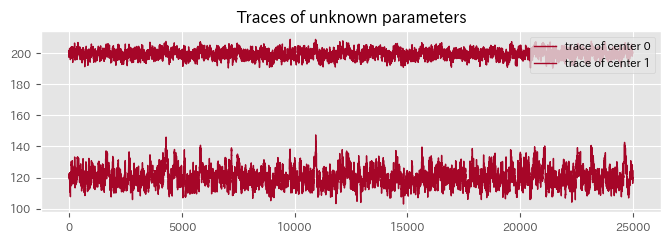

In [15]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
lw = 1
center_trace = trace1["centers"]

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[0], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_trace().set_alpha(0.7)

plt.subplot(312)
std_trace = trace1["sds"]
plt.pot(std_trace[:, 0], label="trace of standard deviation of cluster 0", c=colors[0], lw=lw)
plt.pot(std_trace[:, 1], label="trace of standard deviation of cluster 1", c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace1["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0", color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

同じことをarvizを使ってやると↓

In [ ]:
az.plot_trace(trace2.posterior.centers,figsize=(20, 4))
az.plot_trace(trace2.posterior.sds,figsize=(20, 4))
az.plot_trace(trace2.posterior.p,figsize=(20, 4))
plt.show()

In [ ]:
with model:
    trace3 = pm.sample(50000, step=[step3],tune=5000,chains=1)

In [ ]:
plt.figure(figsize=(8, 3))

sample_data=az.extract_dataset(trace3)
center_trace_after_25000 = sample_data.centers.data[:,25000:]
center_trace_before25000 = sample_data.centers.data[:,:25000]

x = np.arange(25000)
plt.plot(x, center_trace_before25000[0,:], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, center_trace_before25000[1,:], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 50000)
plt.plot(x, center_trace_after_25000[0,: ], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace_after_25000[1,: ], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

In [ ]:
az.plot_trace(trace3.posterior.centers,figsize=(20, 4))
plt.plot()

クラスターを特定するには？
これまでに、事後分布のトレースは取れている。

In [ ]:
plt.figure(figsize=(10, 6))
sample_data = az.extract_dataset(trace3)
std_trace_after25000 = sample_data.sds.data[:, 25000:]
std_trace_before25000 = sample_data.sds.data[:, :25000]

_i = [1, 2, 3, 4]

for i in range(2):
    plt.subplot(2, 2, _i[2*i])
    plt.title(f"Posterior of center of cluster {i}")
    plt.hist(center_trace_after_25000[i,:], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2*i+1])
    plt.title(f"Posterior of standard deviation of cluster {i}")
    plt.hist(std_trace_after_25000[i,:], color=colors[i], bins=30,
             histtype="stepfilled")

plt.tighy_layout()
plt.show()


In [ ]:
az.plot_posterior(trace3,var_names=["sds"],figsize=figsize(16.0, 4))
az.plot_posterior(trace3,var_names=["centers"],figsize=figsize(16.0, 4))
plt.plot()

In [ ]:
sample_data.assignment.data.T

In [ ]:
plt.figure(figsize=(10, 3)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(sample_data.assignment.data.T[::800, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");)